In [1]:
#--------------- Packages ---------------#
%load_ext autoreload
%autoreload 2
import torch
import Corrfunc
import numpy as np
from sbi import utils
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
from sbi.inference.base import infer
from colossus.cosmology import cosmology
from scipy.stats import norm, multivariate_normal
from colossus.halo import concentration, profile_nfw, profile_composite
plt.style.use("CustomizingPlots")
%matplotlib inline

/global/homes/t/titus/.conda/envs/mass_cal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from measure_lensing_v2 import MeasureLensing
from read_mini_uchuu import ReadMiniUchuu
output_loc = '/global/u2/t/titus/Titus/Lensing/output/'
nbody_loc = '/global/u2/t/titus/Titus/Lensing/data/'
lensing_loc = '/global/u2/t/titus/Titus/Lensing/data/McClintock_data/desy1_tamas/'
# plot_loc = '/global/u2/t/titus/Lensing/plots/'

z=0.3
rmu = ReadMiniUchuu(nbody_loc, redshift=z)
xp, yp, zp = rmu.read_particles()

#### halos ####
rmu.read_halos(Mmin=1e13)
# boxsize = rmu.boxsize
xh = rmu.xh
yh = rmu.yh
zh = rmu.zh
mass = rmu.mass
boxsize = rmu.boxsize
rhocrit = 2.775e11
OmegaM = rmu.OmegaM
mpart = rhocrit*OmegaM*boxsize**3/len(xp)

# out_loc = 'data/'
ml = MeasureLensing(nbody_loc, Rmin=-2, Rmax=2.3, pimax=100)
# ml = MeasureLensing(nbody_loc, Rmin=0.0323, Rmax=30, pimax=100)
ml.write_bin_file()

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


## Mass-richness scaling relation

<!-- ### Packages -->

In [3]:
# NOTE: Convert all the functions here into a module.
# Set cosmology
cosmo_params = {'flat': True, 'H0': 67.74, 'Om0': 0.3089, 'Ob0': 0.0486, 'sigma8': 0.8159, 'ns': 0.9667}
cosmology.addCosmology('MiniUchuu', cosmo_params)
cosmo = cosmology.setCosmology('MiniUchuu')
h = cosmo_params['H0']/100
# mass-richness scaling relation
def mrsr(M, M_0, z, sr_type = None, params_path = None):
    if sr_type == "mcclintock": # McClintock, 2019 scaling relation
        # Melchior, 2017 scaling relation
        lam_0 = 30 # Pivot richness
        z_0 = 0.5 # Pivot redshift
        G_z = 0.18 # Redshift scaling index
        F_lam = 1.12 # Richness scaling index
        q_ln_lam = 0.25 #scatter
        
        lam0 = lam_0*(M/(M_0*((1+z)/(1+z_0))**G_z))**(1/F_lam)
        # lam_noisy1 = lam0
        # lam_noisy1 = norm.rvs(lam0, lam0*q_ln_lam)
        lam_noisy1 = norm.rvs(lam0, 0.0)
        
        ln_lam = (np.log(M)-np.log(M_0)-G_z*np.log((1+z)/(1+z_0)))/F_lam + np.log(lam_0)
        ln_lam_noisy = norm.rvs(ln_lam, q_ln_lam, random_state=42)
        # ln_lam_noisy = norm.rvs(ln_lam, 0.0)
        lam_noisy2 = np.exp(ln_lam_noisy)
    return lam_noisy2

def invert_mrsr(lam, M_0, z):
    # Melchior, 2017 scaling relation
    lam_0 = 30 # Pivot richness
    z_0 = 0.5 # Pivot redshift
    G_z = 0.18 # Redshift scaling index
    F_lam = 1.12 # Richness scaling index
    q_ln_lam = 0.25 #scatter
    avg_M = M_0*((lam/lam_0)**F_lam)*((1+z)/(1+z_0))**G_z
    return avg_M

true_mass = mass#[sel]
lam_noiseless2 = mrsr(true_mass*h, 10**14.371, 0.3, "mcclintock") # Melchior scaling relation
lam_noiseless2

array([96.29563546, 74.14774729, 86.28597155, ...,  0.9059358 ,
        2.28910693,  1.12185428])

In [4]:
avg_M = invert_mrsr(lam = lam_noiseless2, M_0 = 10**14.371, z = 0.3)

In [5]:
# Creating richness bins
sel0 = (lam_noiseless2 >= 20)&(lam_noiseless2 < 30)
sel1 = (lam_noiseless2 >= 30)&(lam_noiseless2 < 45)
sel2 = (lam_noiseless2 >= 45)&(lam_noiseless2 < 60)
sel3 = lam_noiseless2 >= 60
std_arr_true_nofit = np.array([np.std(np.log10(true_mass[sel0]*h)), np.std(np.log10(true_mass[sel1]*h)), np.std(np.log10(true_mass[sel2]*h)), np.std(np.log10(true_mass[sel3]*h))])
mean_masses_true_nofit = np.array([np.log10(np.mean(true_mass[sel0]*h)), np.log10(np.mean(true_mass[sel1]*h)), np.log10(np.mean(true_mass[sel2]*h)), np.log10(np.mean(true_mass[sel3]*h))])
print(std_arr_true_nofit)
print(mean_masses_true_nofit)

[0.12608367 0.13154669 0.14123626 0.09628341]
[14.206389 14.402813 14.498789 14.732188]


In [6]:
print(len(true_mass[sel0]), len(true_mass[sel1]), len(true_mass[sel2]), len(true_mass[sel3]))

198 80 20 11


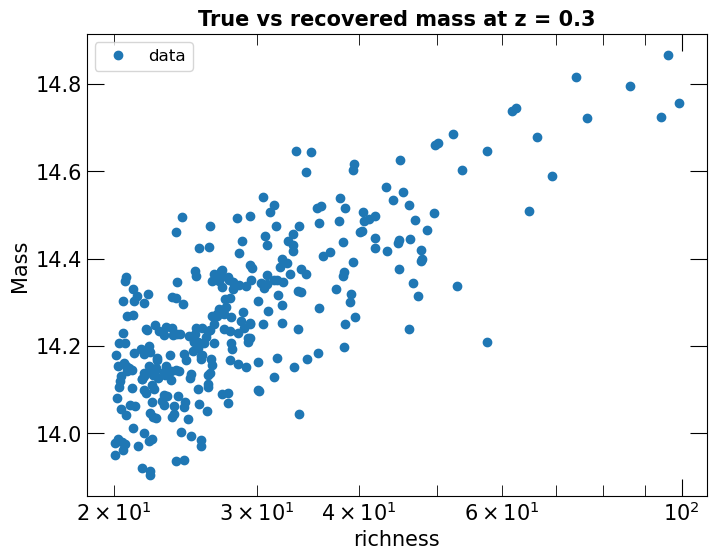

In [7]:
mask = lam_noiseless2 > 20
# x = [20, 30, 45, 60]
# x = [30, 45, 60, 80]
# x = [25, 35, 50, 65]
x = [23.99617, 35.86541, 51.21334, 81.45424] # mean richness of the richness bins

plt.rcParams['figure.figsize'] = (8,6)
# plt.loglog()
plt.xscale("log")
plt.plot(lam_noiseless2[mask], np.log10(true_mass[mask]*h), 'o', label = "data")
plt.title("True vs recovered mass at z = 0.3", fontsize=15)
plt.xlabel("richness", fontsize=15)
plt.ylabel("Mass", fontsize=15)
plt.legend()
plt.show()

### Evrard extra term

#### Fitting extra term

In [8]:
from sklearn.linear_model import LinearRegression
def evrard_extra_term(richness, mass, C, random_state):#, x_cod, y_cod, z_cod):

    # ln_lam0 = np.log(richness) # independent variable X
    all_mass = norm.rvs(mass, 0.25, random_state=random_state)#mass
    # selection = np.exp(richness) >= 20
    ln_lam0 = richness #norm.rvs(richness, 0.25) #richness
    selection = np.exp(ln_lam0) >= 20
    ln_lam = ln_lam0[selection]
    ln_mass = all_mass[selection] # dependent variable Y
    
    # linear regression model
    lm = LinearRegression() # Construct model
    lm.fit(ln_lam.reshape(-1, 1), ln_mass)
    
    # model parameters
    intercept = lm.intercept_ # the intercept (B).
    slope = lm.coef_ # the slope (A).
    rsquared = lm.score(ln_lam.reshape(-1, 1), ln_mass) # the r-squared value
    reg_line = lm.predict(ln_lam.reshape(-1, 1))
    inv_reg_line = (ln_mass - intercept)/slope
    
    # computing alpha and pi
    alpha = 1/slope
    pi = -alpha*(intercept + C)
    C = - (pi/alpha + intercept)
    log_richness0 = alpha*all_mass + pi #no scatter
    return log_richness0, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection, all_mass#, x_cod_new, y_cod_new, z_cod_new
    
def evrard_extra_term2(richness, mass, C):#, x_cod, y_cod, z_cod):
    all_mass = mass
    # selection = np.exp(richness) >= 20
    ln_lam0 = richness #norm.rvs(richness, 0.25) #richness
    selection = np.exp(ln_lam0) >= 20
    ln_lam = ln_lam0[selection]
    ln_mass = all_mass[selection] # dependent variable Y
    
    # linear regression model
    lm = LinearRegression() # Construct model
    lm.fit(ln_lam.reshape(-1, 1), ln_mass)
    
    # model parameters
    intercept = lm.intercept_ # the intercept (B).
    slope = lm.coef_ # the slope (A).
    rsquared = lm.score(ln_lam.reshape(-1, 1), ln_mass) # the r-squared value
    reg_line = lm.predict(ln_lam.reshape(-1, 1))
    inv_reg_line = (ln_mass - intercept)/slope
    
    # computing alpha and pi
    alpha = 1/slope
    pi = -alpha*(intercept + C)
    C = - (pi/alpha + intercept)
    log_richness0 = alpha*all_mass + pi #no scatter
    
    return log_richness0, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection#, x_cod_new, y_cod_new, z_cod_new

In [9]:
# Melchior, 2017 scaling relation
lam_0 = 30 # Pivot richness
z = 0.30 # redshift
z_0 = 0.5 # Pivot redshift
G_z = 0.18 # Redshift scaling index
F_lam = 1.12 # Richness scaling index
q_ln_lam = 0.25 #scatter
Mpivot = 10**14.371 #pivot mass
M = mass*h#[true_mass>=1e14] # mass

fiducial_C = 0.0 # just a random guess
fiducial_alpha = 1/F_lam
fiducial_pi = -(1/F_lam)*(np.log(Mpivot) + G_z*np.log((1+z)/(1+z_0)) - F_lam*np.log(lam_0))
ln_lam = fiducial_alpha*np.log(M) + fiducial_pi
print(ln_lam)

# ln_lam_noisy = norm.rvs(ln_lam, q_ln_lam)
# fiducial_richness = np.exp(ln_lam_noisy)
fiducial_richness = ln_lam #norm.rvs(ln_lam, 0.25) #np.exp(ln_lam)
C_list = [0.0]
M_input = np.log(true_mass*h)
# M_input = norm.rvs(true_mass/h, 0.25)

seed = 6
np.random.seed(seed)
random_states = np.random.randint(0, 100, size=3)

for i,random_state in enumerate(random_states):
    new_richness, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection, all_mass = evrard_extra_term(fiducial_richness, M_input, fiducial_C, random_state)
    fiducial_C = C
    fiducial_alpha = alpha
    fiducial_pi = pi
    fiducial_richness = new_richness
    
    new_richness, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection = evrard_extra_term2(fiducial_richness, all_mass, fiducial_C)
    fiducial_C = C
    fiducial_alpha = alpha
    fiducial_pi = pi
    fiducial_richness = new_richness
    
    # M_input = all_mass
    C_list.append(C)
    # xh, yh, zh = x_cod_new, y_cod_new, z_cod_new
print("C", fiducial_C)
print(fiducial_alpha)
print(fiducial_pi)
print("rsquared", rsquared, "\n")
print(fiducial_richness)

# # selection = richness >= 20
# # Plot log mass vs log richness
# plt.loglog()
# plt.rcParams['figure.figsize'] = (14,6)
# plt.subplot(1, 2, 1)
# plt.scatter(ln_lam, ln_mass, c = "g", label = "richness vs. mass")
# plt.plot(ln_lam, reg_line, "r")
# plt.title("Richness vs mass")
# plt.xlabel("richness")
# plt.ylabel("mass")
# plt.subplot(1, 2, 2) 
# plt.scatter(M_input, new_richness, c = "b", label = "mass vs. richness")
# plt.title("Mass vs richness")
# plt.xlabel("mass")
# plt.ylabel("richness")
# plt.show()

[4.443243   4.340626   4.295744   ... 0.25791168 0.25791168 0.25782204]
C [2.43913018e-07]
[1.00944823]
[-29.74107182]
rsquared 1.0 

[ 4.7782167   5.21728845  4.71886712 ... -0.31763024 -0.3796058
  0.25399215]


In [10]:
richness = np.exp(new_richness) 
# richness = lam_noiseless2
print(len(richness), len(xh))

# Creating richness bins
sel0 = (richness >= 20)&(richness < 30)
sel1 = (richness >= 30)&(richness < 45)
sel2 = (richness >= 45)&(richness < 60)
sel3 = richness >= 60

lam_bin0 = richness[sel0]
lam_bin1 = richness[sel1]
lam_bin2 = richness[sel2]
lam_bin3 = richness[sel3]

print(f'Length of richness bin 1: {len(lam_bin0)}')
print(f'Length of richness bin 2: {len(lam_bin1)}')
print(f'Length of richness bin 3: {len(lam_bin2)}')
print(f'Length of richness bin 4: {len(lam_bin3)}\n')

# mass_true = mass[sel]
mean_mass_true0 = np.mean(true_mass[sel0]) #M_sun
mean_mass_true1 = np.mean(true_mass[sel1])
mean_mass_true2 = np.mean(true_mass[sel2])
mean_mass_true3 = np.mean(true_mass[sel3])

std_arr_true = np.array([np.std(true_mass[sel0]), np.std(true_mass[sel1]), np.std(true_mass[sel2]), np.std(true_mass[sel3])])

print('mean mass 1:', f'{mean_mass_true0:e}')
print('mean mass 2:', f'{mean_mass_true1:e}')
print('mean mass 3:', f'{mean_mass_true2:e}')
print('mean mass 4:', f'{mean_mass_true3:e}\n')

rp_, Sigma0, DeltaSigma0 = ml.measure_lensing(xh[sel0], yh[sel0], zh[sel0], xp, yp, zp, boxsize, mpart)
rp_, Sigma1, DeltaSigma1 = ml.measure_lensing(xh[sel1], yh[sel1], zh[sel1], xp, yp, zp, boxsize, mpart)
rp_, Sigma2, DeltaSigma2 = ml.measure_lensing(xh[sel2], yh[sel2], zh[sel2], xp, yp, zp, boxsize, mpart)
rp_, Sigma3, DeltaSigma3 = ml.measure_lensing(xh[sel3], yh[sel3], zh[sel3], xp, yp, zp, boxsize, mpart)
# print('DeltaSigma1:', DeltaSigma0[:30], '\n')
# print('DeltaSigma2:', DeltaSigma1[:30], '\n')
# print('DeltaSigma3:', DeltaSigma2[:30], '\n')
# print('DeltaSigma4:', DeltaSigma3[:30], '\n')

27275 27275
Length of richness bin 1: 251
Length of richness bin 2: 118
Length of richness bin 3: 50
Length of richness bin 4: 26

mean mass 1: 1.971057e+14
mean mass 2: 2.865907e+14
mean mass 3: 4.064710e+14
mean mass 4: 6.429285e+14

Number of halos 251
Number of halos 118
Number of halos 50


/global/u2/t/titus/Titus/Lensing/codes/GraduateShowcase2024/codes/measure_lensing_v2.py:62: RuntimeWarning: invalid value encountered in divide
  rpavg = np.sum(rpsum_2d, axis=1)/(1.*npairs)
/global/u2/t/titus/Titus/Lensing/codes/GraduateShowcase2024/codes/measure_lensing_v2.py:75: RuntimeWarning: divide by zero encountered in log
  lnSigma_at_lnrp_interp = interp1d(np.log(rpavg), np.log(Sigma_at_rpavg))


Number of halos 26


In [11]:
print('mean mass 1:', f'{np.log10(mean_mass_true0)}')
print('mean mass 2:', f'{np.log10(mean_mass_true1)}')
print('mean mass 3:', f'{np.log10(mean_mass_true2)}')
print('mean mass 4:', f'{np.log10(mean_mass_true3)}\n')

mean mass 1: 14.294698715209961
mean mass 2: 14.45726203918457
mean mass 3: 14.609029769897461
mean mass 4: 14.808162689208984



In [12]:
# # Recovered mass after MCMC fit
# Mobs = np.array([14.28812963, 14.44795361, 14.60701019, 14.78960869]) #Mobs
# std_arr_obs = np.array([0.02715088 , 0.02743035, 0.03615195, 0.03670088]) #std

In [13]:
std_arr_true = np.array([np.std(np.log10(true_mass[sel0])), np.std(np.log10(true_mass[sel1])), np.std(np.log10(true_mass[sel2])), np.std(np.log10(true_mass[sel3]))])
std_arr_true

array([0.11297636, 0.131733  , 0.09763318, 0.12824969], dtype=float32)

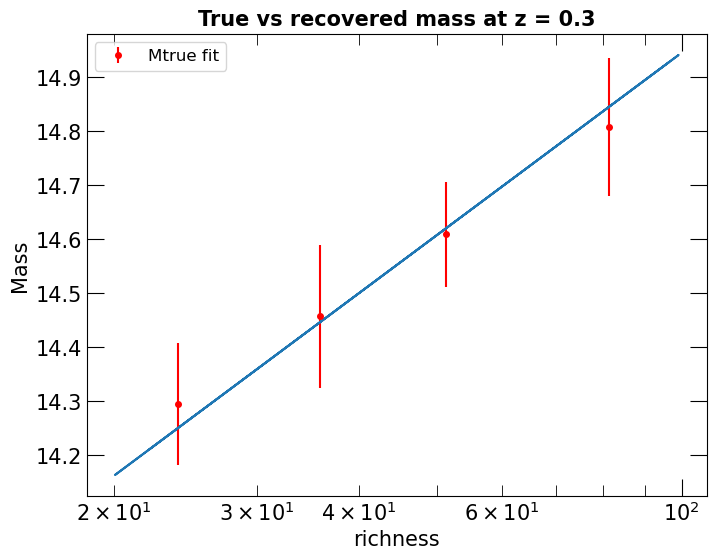

In [14]:
# True mass after MCMC fit
mean_masses_true = np.array([np.log10(mean_mass_true0), np.log10(mean_mass_true1), np.log10(mean_mass_true2), np.log10(mean_mass_true3)]) #new data true_mass*h 
mask = lam_noiseless2 > 20
x = [23.99617, 35.86541, 51.21334, 81.45424] # mean richness of the richness bins

plt.rcParams['figure.figsize'] = (8,6)
# plt.loglog()
plt.xscale("log")
plt.errorbar(x, mean_masses_true, yerr = std_arr_true, 
             fmt = 'o', ms = 4.0, color = 'red',
             label = "Mtrue fit")
# plt.errorbar(x, Mobs, yerr = std_arr_obs, 
#              fmt = 'o', ms = 4.0, color = 'black', 
#              label = "Mobs")
plt.plot(lam_noiseless2[mask], np.log10(avg_M[mask]), '-')
plt.title("True vs recovered mass at z = 0.3", fontsize=15)
plt.xlabel("richness", fontsize=15)
plt.ylabel("Mass", fontsize=15)
plt.legend()
plt.show()

### McClintock Figure 4 (using MiniUchuu data)

In [15]:
# Boost factors
B_dic = {"l3_z0":0.34, "l4_z0":0.37, "l5_z0":0.27, "l6_z0":0.23, 
         "l3_z1":0.05, "l4_z1":0.14, "l5_z1":0.05, "l6_z1":0.21, 
         "l3_z2":0.13, "l4_z2":0.13, "l5_z2":0.09, "l6_z2":0.04}

# Boost factor scale radius
Rs_dic = {"l3_z0":0.44, "l4_z0":0.50, "l5_z0":0.80, "l6_z0":1.37, 
          "l3_z1":0.89, "l4_z1":0.44, "l5_z1":1.72, "l6_z1":0.51, 
          "l3_z2":0.38, "l4_z2":0.44, "l5_z2":0.85, "l6_z2":35.94}

# z_dic = {"0":0.3, "1":0.45, "2":0.6}
z_dic = {"0":0.5*(0.2+0.35), "1":0.5*(0.35+0.5), "2":0.5*(0.5+0.65)}
Am_dic = {"0":1.021, "1":1.14, "2":1.16}

Sigma_crit_dic = {"l3_z0":2.558834359999999819e-04, "l4_z0":2.562248809999999950e-04, 
                  "l5_z0":2.559633569999999851e-04, "l6_z0":2.557816409999999962e-04, 
                  "l3_z1":2.631864830000000188e-04, "l4_z1":2.640424589999999859e-04, 
                  "l5_z1":2.630129280000000004e-04, "l6_z1":2.629873459999999808e-04, 
                  "l3_z2":2.376251149999999903e-04, "l4_z2":2.379116389999999873e-04, 
                  "l5_z2":2.372028870000000031e-04, "l6_z2":2.373956570000000036e-04}

mass_dic = {"l3_z0": mean_mass_true0, "l4_z0": mean_mass_true1, "l5_z0": mean_mass_true2, "l6_z0": mean_mass_true3} # Mass according to richness bins
Sigma_dic = {"l3_z0": Sigma0, "l4_z0": Sigma1, "l5_z0": Sigma2, "l6_z0": Sigma3} # Sigma according to richness bins
DeltaSigma_dic = {"l3_z0": DeltaSigma0, "l4_z0": DeltaSigma1, "l5_z0": DeltaSigma2, "l6_z0": DeltaSigma3} # Delta Sigma according to richness bins
# DeltaSigma_dic["l3_z0"]

In [16]:
from classy import Class
import cluster_toolkit as ctk
from colossus.cosmology import cosmology
from scipy.stats import norm#, multivariate_normal

#Start by specifying the cosmology
Omega_b = cosmo_params['Ob0']
Omega_m = cosmo_params['Om0']
Omega_cdm = Omega_m - Omega_b
sigma8 = cosmo_params['sigma8']
h = cosmo_params['H0']/100 # McClintock h value
A_s = 2.1e-9 #np.exp(3.064)/1e10 NB: ln(1e10*As)=3.064
n_s = cosmo_params['ns']
# z = 0.3

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 1000 #UNITS: 1/Mpc

params = {
         'output':'mPk',
         'h':h,
         'sigma8':sigma8,
         'n_s':n_s,
         'Omega_b':Omega_b,
         'Omega_cdm':Omega_cdm,
         'P_k_max_1/Mpc':k_max,
         'z_max_pk':1.0, #Default value is 10
         'non linear':'halofit'
}

#Initialize the cosmology and compute everything
cosmo_ctk = Class()
cosmo_ctk.set(params)
cosmo_ctk.compute()

In [17]:
rp = np.array([ 0.04221139,  0.06651455,  0.10516441,  0.16537565,  0.26069825, 
               0.41202975,  0.65045543,  1.02563815,  1.61857299,  2.55379112, 
               4.02731114,  6.34991963, 10.00980414, 15.784786  , 24.87216972])
def add_sys_to_data(mass, DS_data08, Sigma_data08, Rs, B0, Am, z, lam, Rp_mid):
    tau = 0.17
    fmis = 0.25

    # mass = mass0/h
    c = concentration.concentration(M=mass, mdef='200m', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
    # computing miscentering corrections
    Rlam = (lam/100)**0.2 #Mpc/h comoving
    Rmis = tau*Rlam #Mpc/h Radial miscentering offset. Cluster centers are wrongly identified by a distance Rmis.
    
    # McClintock radial bins
    Rmin = 0.0323
    Rmax = 30
    nbins = 15
    # rp = rp_
    Rproj = rp_
    # Rproj = np.logspace(-2, 2.3, num=1000, base=10)#*h*(1+z)
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z) #Converted to Mpc/h comoving
    # Rp_mid = (Redges[:-1]+Redges[1:])/2
    
    # DeltaSigma (excess surface density)
    # DS_theory = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma_data08, mass, c, Omega_m) #DeltaSigma
    # print(DS_theory)
    Sigma_mis8  = ctk.miscentering.Sigma_mis_at_R(Rproj, Rproj, Sigma_data08, mass, c, Omega_m, Rmis, kernel="gamma") #miscentered Sigma profiles
    DS_mis8 = ctk.miscentering.DeltaSigma_mis_at_R(Rproj, Rproj, Sigma_mis8) #miscentered Sigma profiles
    full_Sigma = (1-fmis)*Sigma_data08 + fmis*Sigma_mis8 
    
    DS_data8 = (1-fmis)*DS_data08 + fmis*DS_mis8 # miscentered (from theory) + correctly centered DeltaSigma profiles
    DS_data8 *= Am # multiplicative bias

    # Compute boost factors from cluster toolkit
    boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs*h*(1+z)) # to correct for dilution effects
    # boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs) # to correct for dilution effects
    DS_data8 /= boost_model # de-boost the model
    Sigma_crit_inv = Sigma_crit_inv0*h*(1+z)**2
    DS_data8 /= (1-full_Sigma*Sigma_crit_inv) #Reduced shear
    DS_data_final = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS_data8)
    DS_data_final *= h*(1+z)**2 #convert to Msun/pc^2 physical
    
    # boost_model2 = ctk.boostfactors.boost_nfw_at_R(Rp_mid, B0, Rs*h*(1+z)) #theory
    boost_model2 = ctk.boostfactors.boost_nfw_at_R(Rp_mid, B0, Rs) #theory
    return DS_data_final, boost_model2

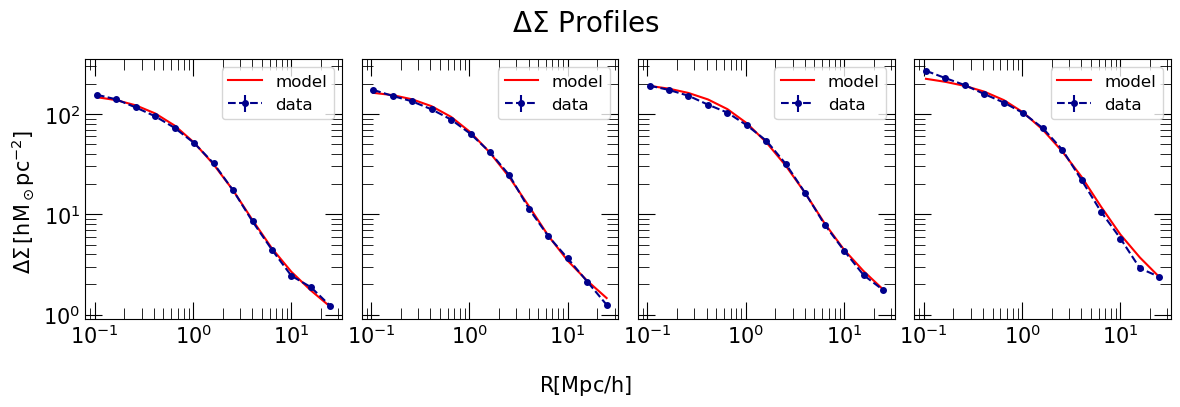

In [18]:
from cluster_toolkit import miscentering

z = 0.3
a = 1/(1+z)
a2 = a**2
Am = 1.021 #Am_dic[l3_z0] 

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=4000) #Mpc^-1 comoving

# Power spectrum
Pnonlin = np.array([cosmo_ctk.pk(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
Plin = np.array([cosmo_ctk.pk_lin(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
kh = k/h #h/Mpc comoving

#P(k) are in Mpc^3/h^3 comoving
#Thus, you will need to convert these to h/Mpc and (Mpc/h)^3 to use in the toolkit.
Plin *= h**3
Pnonlin *= h**3

# Create a figure and four subplots (1 row, 4 columns)
drop = 1
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True, sharex = True)
# files_list = []
for j in range(4):
    if j+3 == 3:
        lam = 25.0
        # lam = 0.5*(20.0+30.0)
    elif j+3 == 4:
        lam = 40.0
        # lam = 0.5*(30.0+45.0)
    elif j+3 == 5:
        lam = 55.0
        # lam = 0.5*(45.0+60.0)
    elif j+3 == 6:
        lam = 82.0
    # print(lam)

    ########################################### 
    # parameters
    lam_z_bin = "l"+str(j+3)+"_z0"
    mass = mass_dic[lam_z_bin]
    c = concentration.concentration(M=mass, mdef='200m', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
    # c = 5.81 #c_dic[lam_z_bin]
    Rs = Rs_dic[lam_z_bin] #0.44 
    B0 = B_dic[lam_z_bin] #0.34 
    tau = 0.17
    fmis = 0.25
    Sigma_crit_inv0 = Sigma_crit_dic[lam_z_bin] #2.558834359999999819e-04 
    
    # computing miscentering corrections
    Rlam = (lam/100)**0.2 #Mpc/h comoving
    Rmis = tau*Rlam #Mpc/h Radial miscentering offset. Cluster centers are wrongly identified by a distance Rmis.
    # Rproj = rp_
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii. 
    R3d = np.logspace(-2, 3, num=1000, base=10) #Mpc/h comoving. 3D radii.
    
    # rp in comoving Mpc/h
    Rmin = 0.0323 
    Rmax = 30 
    nbins = 15
    
    # rp1 = rp_
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    # Redges = np.logspace(np.log10(0.0323), np.log10(30.), num=15+1) #Projected radial bin edges
    # Redges2 = Redges*(h*(1+z)) #Converted to Mpc/h comoving
    Redges *= h*(1+z) #Converted to Mpc/h comoving
    # rp1 = (Redges[:-1]+Redges[1:])/2
    
    ##############################
    # Incorporating systematic effects into the simulated profiles
    Sigma_data08 = Sigma_dic[lam_z_bin] # Sigma profile
    DS_data08 = DeltaSigma_dic[lam_z_bin] # DeltaSigma profile
    DS_data8 = add_sys_to_data(mass, DS_data08, Sigma_data08, Rs, B0, Am, z, lam, rp)[0]
    ##############################
    
    # NFW profile
    xi_nfw = ctk.xi.xi_nfw_at_r(R3d, mass, c, Omega_m)
    
    # Matter-matter correlation function (matter auto-correlation)
    # xi_mm = xi.xi_mm_at_r(r, k, Plin)
    xi_mm = ctk.xi.xi_mm_at_r(R3d, kh, Pnonlin)
    
     # 2-halo correlation function
    bias_term = ctk.bias.bias_at_M(mass, kh, Plin, Omega_m) # Here, P must be linear.
    xi_2halo = ctk.xi.xi_2halo(bias_term, xi_mm)
    
    # Halo-matter correlation function
    xi_hm = ctk.xi.xi_hm(xi_nfw, xi_2halo)
    
    # Sigma (computed from xi_hm)
    Sigma = ctk.deltasigma.Sigma_at_R(Rproj, R3d, xi_hm, mass, c, Omega_m) #Sigma
    
    # DeltaSigma (excess surface density)
    # mass = mass/h
    DS_theory = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma, mass, c, Omega_m) #DeltaSigma
    # print(DS_theory)
    Sigma_mis = ctk.miscentering.Sigma_mis_at_R(Rproj, Rproj, Sigma, mass, c, Omega_m, Rmis, kernel="gamma") #miscentered Sigma profiles
    # print(Sigma_mis)
    DS_mis = ctk.miscentering.DeltaSigma_mis_at_R(Rproj, Rproj, Sigma_mis) #miscentered Sigma profiles
    # print(DS_mis)
    #full Sigma profile; i.e. miscentered + correctly centered Sigma profiles
    full_Sigma = (1-fmis)*Sigma + fmis*Sigma_mis 
    #full DeltaSigma profile; i.e. miscentered + correctly centered DeltaSigma profiles
    full_DS = (1-fmis)*DS_theory + fmis*DS_mis 
    full_DS *= Am #multiplicative bias
    
    # Compute boost factors from cluster toolkit
    #Note: Rs is default in Mpc physical
    boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs*h*(1+z)) #theory
    # boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs) #theory

    full_DS /= boost_model #de-boost the model
    Sigma_crit_inv = Sigma_crit_inv0*h*(1+z)**2
    #Here, DeltaSigma is in Msun h/pc^2 comoving
    full_DS /= (1-full_Sigma*Sigma_crit_inv) #Reduced shear

    ave_DS = ctk.averaging.average_profile_in_bins(Redges, Rproj, full_DS)
    ave_DS *= h*(1+z)**2 #convert to Msun/pc^2 physical

    # print(DS_data8)
    # print(ave_DS, "\n")
    inds = (rp > 0.1)*(rp < 999) 
    rp2 = rp[inds]
    
    label = "data"
    axes[j].loglog()

    ########################
    # axes[j].set_ylim(9.0, 1.2e2)
    axes[j].errorbar(rp2, DS_data8[inds], yerr = np.zeros(len(rp2)), fmt = '--o', 
                        ms = 4.0, color = 'darkblue', 
                        label = label)
    axes[j].plot(rp2, ave_DS[inds], "-r", label = "model")
    axes[j].legend()
        
# Add a super title, super x label, and super y label
fig.suptitle(r'$\Delta\Sigma$ Profiles', fontsize=20)
fig.supxlabel(r"$\rm R [Mpc/h]$", fontsize=15)
fig.supylabel(r"$\rm \Delta\Sigma\,[hM_\odot \mathrm{pc}^{-2}]$", fontsize=15)

# Adjust spacing between subplots
plt.tight_layout(h_pad = 0.0, w_pad = 0.2)
plt.show()

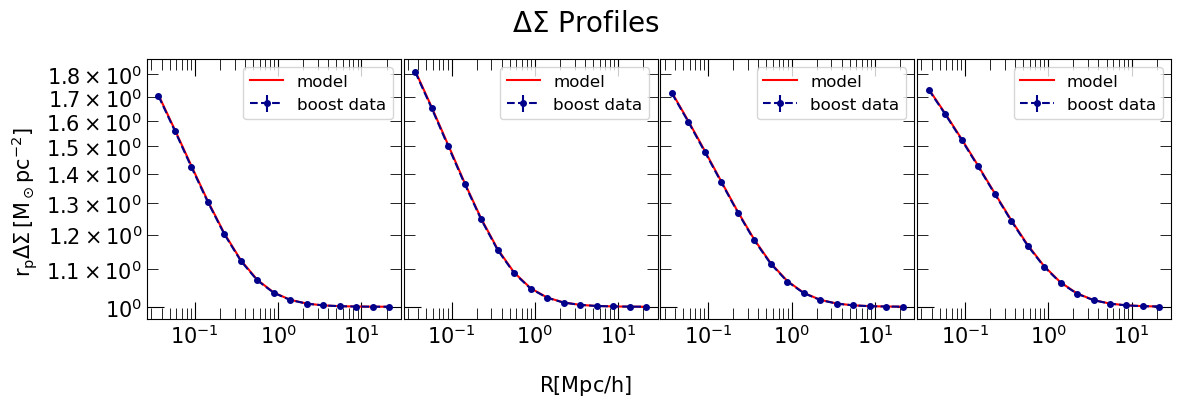

In [19]:
from cluster_toolkit import miscentering

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True, sharex = True)
# files_list = []
for j in range(4):
    if j+3 == 3:
        lam = 25.0
        # lam = 0.5*(20.0+30.0)
    elif j+3 == 4:
        lam = 40.0
        # lam = 0.5*(30.0+45.0)
    elif j+3 == 5:
        lam = 55.0
        # lam = 0.5*(45.0+60.0)
    elif j+3 == 6:
        lam = 82.0

    ########################################### 
    # parameters
    lam_z_bin = "l"+str(j+3)+"_z0"
    Rs = Rs_dic[lam_z_bin] #0.44 
    B0 = B_dic[lam_z_bin] #0.34 
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii.
    mass = mass_dic[lam_z_bin]
    
    # rp in comoving Mpc/h
    Rmin = 0.0323 
    Rmax = 30 
    nbins = 15
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z) #Converted to Mpc/h comoving
    rp1 = (Redges[:-1]+Redges[1:])/2
    
    # Compute boost factors from cluster toolkit
    #Note: Rs is default in Mpc physical
    boost_model = ctk.boostfactors.boost_nfw_at_R(rp1, B0, Rs*h*(1+z)) #theory
    
    Sigma_data08 = Sigma_dic[lam_z_bin] # Sigma profile
    DS_data08 = DeltaSigma_dic[lam_z_bin] # DeltaSigma profile
    boost_data = add_sys_to_data(mass, DS_data08, Sigma_data08, Rs, B0, Am, z, lam, rp)[1]
    
    # print(boost_data)
    # print(boost_model, "\n")
    
    inds = (rp1 > 0.0)*(rp1 < 999) 
    # inds = rp1 > 0.0
    rp2 = rp1[inds]
    
    label = "boost data"
    axes[j].loglog()

    ########################
    # axes[j].set_ylim(0.4, 3.5e2)
    axes[j].errorbar(rp2, boost_data[inds], yerr = np.zeros(len(rp2)), fmt = '--o', 
                        ms = 4.0, color = 'darkblue', 
                        label = label)
    axes[j].plot(rp2, boost_model[inds], "-r", label = "model")
    axes[j].legend()
        
# Add a super title, super x label, and super y label
fig.suptitle(r'$\Delta\Sigma$ Profiles', fontsize=20)
fig.supxlabel(r"$\rm R [Mpc/h]$", fontsize=15)
# fig.supylabel(r"$\rm \Delta\Sigma\,[M_\odot \mathrm{pc}^{-2}]$", fontsize=15)
fig.supylabel(r"$\rm r_p\Delta\Sigma\,[M_\odot \mathrm{pc}^{-2}]$", fontsize=15)

# Adjust spacing between subplots
plt.tight_layout(h_pad = 0.0, w_pad = 0.2)
plt.show()